# Assignment 3

Name: Saddam Hossain


# Call the important lib. and prepare the dataset

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# The folder of you dataset on your desk
data_dir = "signlanguage"

In [3]:
# Image Size
batch_size = 40
img_height = 200
img_width = 200

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="training",
  seed=125,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8476 files belonging to 25 classes.
Using 5086 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.5,
  subset="validation",
  seed=130,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 8476 files belonging to 25 classes.
Using 4238 files for validation.


In [6]:
from tensorflow.keras import layers
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [7]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.054901965 1.0


In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Build your Model

In [19]:
num_classes = 25
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
    layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
  layers.Dense(num_classes, activation="softmax")
])

In [20]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [21]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
128/128 [==============================] - 83s 645ms/step - loss: 3.0033 - accuracy: 0.1180 - val_loss: 1.8595 - val_accuracy: 0.4799

# Transfer Learning

## Use data augmentation

In [22]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
IMG_SIZE = (img_height, img_width)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [24]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(40, 7, 7, 1280)


## Feature extraction

### Freeze the convolutional base

In [25]:
base_model.trainable = False

In [27]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 100, 100, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 100, 100, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 100, 100, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Add a classification head

In [28]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(40, 1280)


In [29]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(40, 1)


In [30]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [31]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [33]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 200, 200, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 200, 200, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 200, 200, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 1280)              0     

In [36]:
len(model.trainable_variables)

2

## Train the model

In [37]:
loss0, accuracy0 = model.evaluate(val_ds)

106/106 [==============================] - 36s 326ms/step - loss: -28.7396 - accuracy: 0.0573

In [38]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: -28.74
initial accuracy: 0.06


In [39]:
initial_epochs = 7
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
128/128 [==============================] - 85s 644ms/step - loss: -60.8578 - accuracy: 0.0604 - val_loss: -109.7751 - val_accuracy: 0.0573

## Learning curves

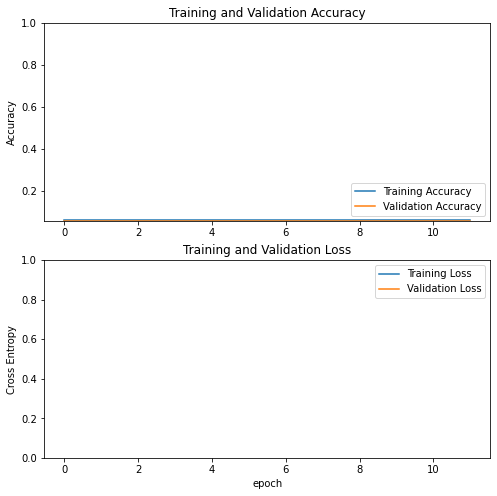

In [49]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

### Un-freeze the top layers of the model

In [43]:
base_model.trainable = True

In [44]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model

In [45]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 200, 200, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 200, 200, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 200, 200, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 1280)              0     

### Continue training the model

In [47]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/11
128/128 [==============================] - 128s 971ms/step - loss: -8469.8760 - accuracy: 0.0604 - val_loss: -9868.8760 - val_accuracy: 0.0573

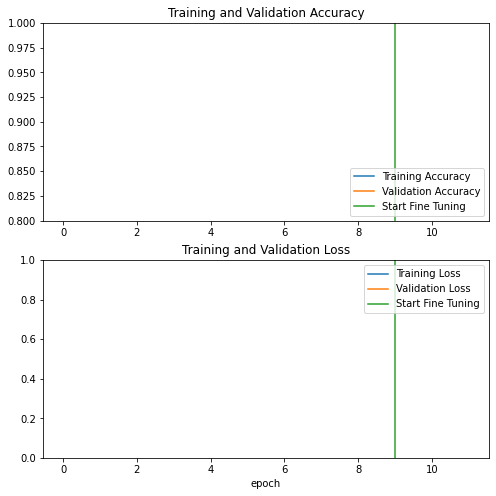

In [48]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Conclusion

At first, use Tensorflow frameworks to finish this problem.  from directory take dataset for build training and validation dataset. Furthermore, for normalization do the rescaling then build the model to get better results. Finally, compile the model and fit the model to select the best results.

Transfer learning is best even if you model is good. Because it is very powerful and increasing popularity in future. Data augmentation was used to expand the training samples and to improve generalization. MobileNetV2 improves the state-of-the-art performance of mobile models on multiple tasks and benchmarks as well as across a spectrum of different model sizes. There has been also used fine-tuning then compile the model again to get better accuracy.

The experimental results show that our proposed CNN model with good architecture can classify different field crop insects robustly and achieved good performance than transfer learning models.